## Library imports

In [1]:
import pandas as pd
import numpy as np
import librosa
import IPython.display as ipd
import noisereduce as nr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import os
import pickle

# import swifter
### tqdm pandas is incompatible with swifter
from tqdm import tqdm
tqdm.pandas()

# from ydata_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt
# pd.options.plotting.backend = "plotly"


In [2]:
# import warnings
# warnings.filterwarnings("ignore")

In [3]:
# from preprocessing_pipeline import *
# from eda_pipeline import *

In [4]:
import preprocessing_pipeline as pp_pipe

In [5]:
from util import data_address
data_address 

'./data/'

In [6]:
n_fft = 2048
n_mels = 128
n_mfcc = 20
SAVE_FILE_NAME = f'df_processed_stat_no_trim_no_clean_fft{n_fft}_mel{n_mels}_mfcc{n_mfcc}.pkl'

In [7]:
FILE_DIR = data_address+"VOiCES_devkit/"

In [8]:
df_raw = pd.read_pickle(data_address+"df_merged.pkl")
df_raw.drop(['index'],axis=1,inplace=True)
df_raw

,chapter,degrees,distractor,filename,gender,mic,query_name,room,segment,source,speaker,transcript,noisy_length,noisy_sr,noisy_time,source_length,source_sr,source_time,category
0,32639,160,babb,distant-16k/speech/test/rm4/babb/sp4899/Lab41-...,F,1,Lab41-SRI-VOiCES-rm4-babb-sp4899-ch032639-sg00...,rm4,29,source-16k/test/sp4899/Lab41-SRI-VOiCES-src-sp...,4899,and i got on with the lesson very badly i am s...,255040,16000,15.940,255040,16000,15.940,test
1,32639,160,babb,distant-16k/speech/test/rm4/babb/sp4899/Lab41-...,F,5,Lab41-SRI-VOiCES-rm4-babb-sp4899-ch032639-sg00...,rm4,29,source-16k/test/sp4899/Lab41-SRI-VOiCES-src-sp...,4899,and i got on with the lesson very badly i am s...,255040,16000,15.940,255040,16000,15.940,test
2,32658,70,babb,distant-16k/speech/test/rm4/babb/sp4899/Lab41-...,F,5,Lab41-SRI-VOiCES-rm4-babb-sp4899-ch032658-sg00...,rm4,12,source-16k/test/sp4899/Lab41-SRI-VOiCES-src-sp...,4899,and ran upstairs to put away the host of littl...,258000,16000,16.125,258000,16000,16.125,test
3,32658,70,babb,distant-16k/speech/test/rm4/babb/sp4899/Lab41-...,F,1,Lab41-SRI-VOiCES-rm4-babb-sp4899-ch032658-sg00...,rm4,12,source-16k/test/sp4899/Lab41-SRI-VOiCES-src-sp...,4899,and ran upstairs to put away the host of littl...,258000,16000,16.125,258000,16000,16.125,test
4,130550,10,babb,distant-16k/speech/test/rm4/babb/sp1447/Lab41-...,F,1,Lab41-SRI-VOiCES-rm4-babb-sp1447-ch130550-sg00...,rm4,26,source-16k/test/sp1447/Lab41-SRI-VOiCES-src-sp...,1447,he was inexhaustibly voluble,58720,16000,3.670,58720,16000,3.670,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,162129,160,none,distant-16k/speech/train/rm4/none/sp2673/Lab41...,M,1,Lab41-SRI-VOiCES-rm4-none-sp2673-ch162129-sg00...,rm4,27,source-16k/train/sp2673/Lab41-SRI-VOiCES-src-s...,2673,and away with it we ought all to say if social...,239840,16000,14.990,239840,16000,14.990,train
19196,75242,170,none,distant-16k/speech/train/rm4/none/sp1212/Lab41...,F,5,Lab41-SRI-VOiCES-rm4-none-sp1212-ch075242-sg00...,rm4,16,source-16k/train/sp1212/Lab41-SRI-VOiCES-src-s...,1212,and zip dropped from the boy's arms not into t...,269040,16000,16.815,269040,16000,16.815,train
19197,75242,170,none,distant-16k/speech/train/rm4/none/sp1212/Lab41...,F,1,Lab41-SRI-VOiCES-rm4-none-sp1212-ch075242-sg00...,rm4,16,source-16k/train/sp1212/Lab41-SRI-VOiCES-src-s...,1212,and zip dropped from the boy's arms not into t...,269040,16000,16.815,269040,16000,16.815,train
19198,14653,160,none,distant-16k/speech/train/rm4/none/sp1212/Lab41...,F,1,Lab41-SRI-VOiCES-rm4-none-sp1212-ch014653-sg00...,rm4,3,source-16k/train/sp1212/Lab41-SRI-VOiCES-src-s...,1212,for for the sake of my reputation i suggested ...,256080,16000,16.005,256080,16000,16.005,train


##

In [9]:
df_raw.isna().sum()

chapter          0
degrees          0
distractor       0
filename         0
gender           0
mic              0
query_name       0
room             0
segment          0
source           0
speaker          0
transcript       0
noisy_length     0
noisy_sr         0
noisy_time       0
source_length    0
source_sr        0
source_time      0
category         0
dtype: int64

In [10]:
# ## eda.py

def process_audio(signal, sr, length=15, n_fft=2048, n_mels=128, n_mfcc=20):
    """
    Process audio signal
    """
    spectrogram = pp_pipe.compute_spectrogram(signal, n_fft=n_fft)
    spectrogram = pp_pipe.convert_to_decibel(spectrogram)
    melspectrogram = pp_pipe.compute_melspectrogram(spectrogram, n_mels=n_mels)
    mfcc = pp_pipe.compute_mfcc(melspectrogram, n_mfcc=n_mfcc)
    return (spectrogram, melspectrogram, mfcc)


def descriptive_statistics(arr):
    n_mean = arr.mean()
    n_std = arr.std()

    return (n_mean, n_std)

def map_columns_statistics(row,spectrogram,column_name):
    for i in range(spectrogram.shape[0]):
        n_mean, n_std = descriptive_statistics(spectrogram[i])
        row[column_name+'_'+str(i)+'_mean'] = n_mean
        row[column_name+'_'+str(i)+'_std'] = n_std

    return row

def apply_process_signal(row,n_fft=2048, n_mels=128, n_mfcc=20):
    filename = row['filename']
    signal, sr = librosa.load(FILE_DIR+filename)
    _,melspectrogram,mfcc = process_audio(signal,sr,n_fft=n_fft, n_mels=n_mels, n_mfcc=n_mfcc)
    
    row = map_columns_statistics(row,melspectrogram,'mel')
    row = map_columns_statistics(row,mfcc,'mfcc')
        
    return row



    

In [11]:
temp = df_raw.iloc[:2,:].progress_apply(apply_process_signal,n_fft=n_fft, n_mels=n_mels, n_mfcc=n_mfcc, axis=1)
# temp = df_raw.iloc[:2,:].swifter.apply(apply_process_signal,n_fft=n_fft, n_mels=n_mels, n_mfcc=n_mfcc, axis=1)

print(temp.columns)
temp

100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

Index(['chapter', 'degrees', 'distractor', 'filename', 'gender', 'mic',
       'query_name', 'room', 'segment', 'source',
       ...
       'mfcc_15_mean', 'mfcc_15_std', 'mfcc_16_mean', 'mfcc_16_std',
       'mfcc_17_mean', 'mfcc_17_std', 'mfcc_18_mean', 'mfcc_18_std',
       'mfcc_19_mean', 'mfcc_19_std'],
      dtype='object', length=315)


,chapter,degrees,distractor,filename,gender,mic,query_name,room,segment,source,...,mfcc_15_mean,mfcc_15_std,mfcc_16_mean,mfcc_16_std,mfcc_17_mean,mfcc_17_std,mfcc_18_mean,mfcc_18_std,mfcc_19_mean,mfcc_19_std
0,32639,160,babb,distant-16k/speech/test/rm4/babb/sp4899/Lab41-...,F,1,Lab41-SRI-VOiCES-rm4-babb-sp4899-ch032639-sg00...,rm4,29,source-16k/test/sp4899/Lab41-SRI-VOiCES-src-sp...,...,-0.234926,0.635863,0.069191,0.612828,-0.034859,0.597315,0.063703,0.720811,0.255371,0.656739
1,32639,160,babb,distant-16k/speech/test/rm4/babb/sp4899/Lab41-...,F,5,Lab41-SRI-VOiCES-rm4-babb-sp4899-ch032639-sg00...,rm4,29,source-16k/test/sp4899/Lab41-SRI-VOiCES-src-sp...,...,-0.255411,0.530061,0.675375,0.504203,-0.063383,0.559009,0.348555,0.550831,0.087109,0.549244


In [12]:
# Check if the file exists
file_path = data_address + SAVE_FILE_NAME
if os.path.exists(file_path):
    # If the file exists, read the pickle file
    with open(file_path, 'rb') as file:
        df_processed = pd.read_pickle(file_path)
else:
    # If the file doesn't exist, do the rest of the steps
    df_processed = df_raw.progress_apply(apply_process_signal,n_fft=n_fft, n_mels=n_mels, n_mfcc=n_mfcc, axis=1)
    # df_processed = df_raw.apply(apply_process_signal,n_fft=n_fft, n_mels=n_mels, n_mfcc=n_mfcc, axis=1)
    df_processed.to_pickle(file_path)


df_processed.info()

100%|██████████| 19200/19200 [33:53<00:00,  9.44it/s] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19200 entries, 0 to 19199
Columns: 315 entries, chapter to mfcc_19_std
dtypes: float64(298), int64(9), object(8)
memory usage: 46.1+ MB


In [13]:
df_processed

,chapter,degrees,distractor,filename,gender,mic,query_name,room,segment,source,...,mfcc_15_mean,mfcc_15_std,mfcc_16_mean,mfcc_16_std,mfcc_17_mean,mfcc_17_std,mfcc_18_mean,mfcc_18_std,mfcc_19_mean,mfcc_19_std
0,32639,160,babb,distant-16k/speech/test/rm4/babb/sp4899/Lab41-...,F,1,Lab41-SRI-VOiCES-rm4-babb-sp4899-ch032639-sg00...,rm4,29,source-16k/test/sp4899/Lab41-SRI-VOiCES-src-sp...,...,-0.234926,0.635863,0.069191,0.612828,-0.034859,0.597315,0.063703,0.720811,0.255371,0.656739
1,32639,160,babb,distant-16k/speech/test/rm4/babb/sp4899/Lab41-...,F,5,Lab41-SRI-VOiCES-rm4-babb-sp4899-ch032639-sg00...,rm4,29,source-16k/test/sp4899/Lab41-SRI-VOiCES-src-sp...,...,-0.255411,0.530061,0.675375,0.504203,-0.063383,0.559009,0.348555,0.550831,0.087109,0.549244
2,32658,70,babb,distant-16k/speech/test/rm4/babb/sp4899/Lab41-...,F,5,Lab41-SRI-VOiCES-rm4-babb-sp4899-ch032658-sg00...,rm4,12,source-16k/test/sp4899/Lab41-SRI-VOiCES-src-sp...,...,-1.068465,0.574085,-0.235911,0.546243,-0.853227,0.587465,-0.019368,0.561328,-0.570055,0.545911
3,32658,70,babb,distant-16k/speech/test/rm4/babb/sp4899/Lab41-...,F,1,Lab41-SRI-VOiCES-rm4-babb-sp4899-ch032658-sg00...,rm4,12,source-16k/test/sp4899/Lab41-SRI-VOiCES-src-sp...,...,-1.113704,0.676677,-0.678982,0.595795,-0.532142,0.603103,-0.572886,0.632340,-0.278188,0.618203
4,130550,10,babb,distant-16k/speech/test/rm4/babb/sp1447/Lab41-...,F,1,Lab41-SRI-VOiCES-rm4-babb-sp1447-ch130550-sg00...,rm4,26,source-16k/test/sp1447/Lab41-SRI-VOiCES-src-sp...,...,-1.334682,0.581327,-0.600092,0.462664,-0.766244,0.426755,-0.498948,0.534863,-0.129595,0.435491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,162129,160,none,distant-16k/speech/train/rm4/none/sp2673/Lab41...,M,1,Lab41-SRI-VOiCES-rm4-none-sp2673-ch162129-sg00...,rm4,27,source-16k/train/sp2673/Lab41-SRI-VOiCES-src-s...,...,-0.402409,0.609593,0.631586,0.602320,-0.026373,0.694410,0.401211,0.501564,0.643355,0.691259
19196,75242,170,none,distant-16k/speech/train/rm4/none/sp1212/Lab41...,F,5,Lab41-SRI-VOiCES-rm4-none-sp1212-ch075242-sg00...,rm4,16,source-16k/train/sp1212/Lab41-SRI-VOiCES-src-s...,...,-0.190316,0.543521,1.392509,0.523867,-0.305557,0.553666,0.181702,0.565212,0.654781,0.634878
19197,75242,170,none,distant-16k/speech/train/rm4/none/sp1212/Lab41...,F,1,Lab41-SRI-VOiCES-rm4-none-sp1212-ch075242-sg00...,rm4,16,source-16k/train/sp1212/Lab41-SRI-VOiCES-src-s...,...,-0.202829,0.609548,0.864445,0.547282,-0.030312,0.622354,0.055463,0.547460,0.980605,0.642305
19198,14653,160,none,distant-16k/speech/train/rm4/none/sp1212/Lab41...,F,1,Lab41-SRI-VOiCES-rm4-none-sp1212-ch014653-sg00...,rm4,3,source-16k/train/sp1212/Lab41-SRI-VOiCES-src-s...,...,-0.529172,0.571464,0.620648,0.544762,0.627302,0.476814,0.100000,0.540052,0.024584,0.504623


In [14]:
print(list(df_processed.columns))

['chapter', 'degrees', 'distractor', 'filename', 'gender', 'mic', 'query_name', 'room', 'segment', 'source', 'speaker', 'transcript', 'noisy_length', 'noisy_sr', 'noisy_time', 'source_length', 'source_sr', 'source_time', 'category', 'mel_0_mean', 'mel_0_std', 'mel_1_mean', 'mel_1_std', 'mel_2_mean', 'mel_2_std', 'mel_3_mean', 'mel_3_std', 'mel_4_mean', 'mel_4_std', 'mel_5_mean', 'mel_5_std', 'mel_6_mean', 'mel_6_std', 'mel_7_mean', 'mel_7_std', 'mel_8_mean', 'mel_8_std', 'mel_9_mean', 'mel_9_std', 'mel_10_mean', 'mel_10_std', 'mel_11_mean', 'mel_11_std', 'mel_12_mean', 'mel_12_std', 'mel_13_mean', 'mel_13_std', 'mel_14_mean', 'mel_14_std', 'mel_15_mean', 'mel_15_std', 'mel_16_mean', 'mel_16_std', 'mel_17_mean', 'mel_17_std', 'mel_18_mean', 'mel_18_std', 'mel_19_mean', 'mel_19_std', 'mel_20_mean', 'mel_20_std', 'mel_21_mean', 'mel_21_std', 'mel_22_mean', 'mel_22_std', 'mel_23_mean', 'mel_23_std', 'mel_24_mean', 'mel_24_std', 'mel_25_mean', 'mel_25_std', 'mel_26_mean', 'mel_26_std', 'mel

In [15]:
df_corr = df_processed.drop(['chapter', 'degrees', 'distractor', 'filename', 'gender', 'mic', 'query_name', 'room', 'segment', 'source', 'transcript', 'noisy_length', 'noisy_sr', 'noisy_time', 'source_length', 'source_sr', 'source_time', 'category']
,axis = 1)

In [16]:
df_processed_2 = df_processed.drop(['chapter', 'filename',  'query_name', 'segment', 'source', 'transcript', 'noisy_length', 'noisy_sr', 'noisy_time', 'source_sr']
,axis = 1)

In [17]:
for i in df_processed_2.dtypes:
    print(i)

int64
object
object
int64
object
int64
int64
float64
object
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
floa

In [18]:
for col in df_processed_2.select_dtypes(exclude=['number', 'bool', 'float64','int64']).columns:
    le = LabelEncoder()
    df_processed_2[col] = le.fit_transform(df_processed_2[col].astype(str))

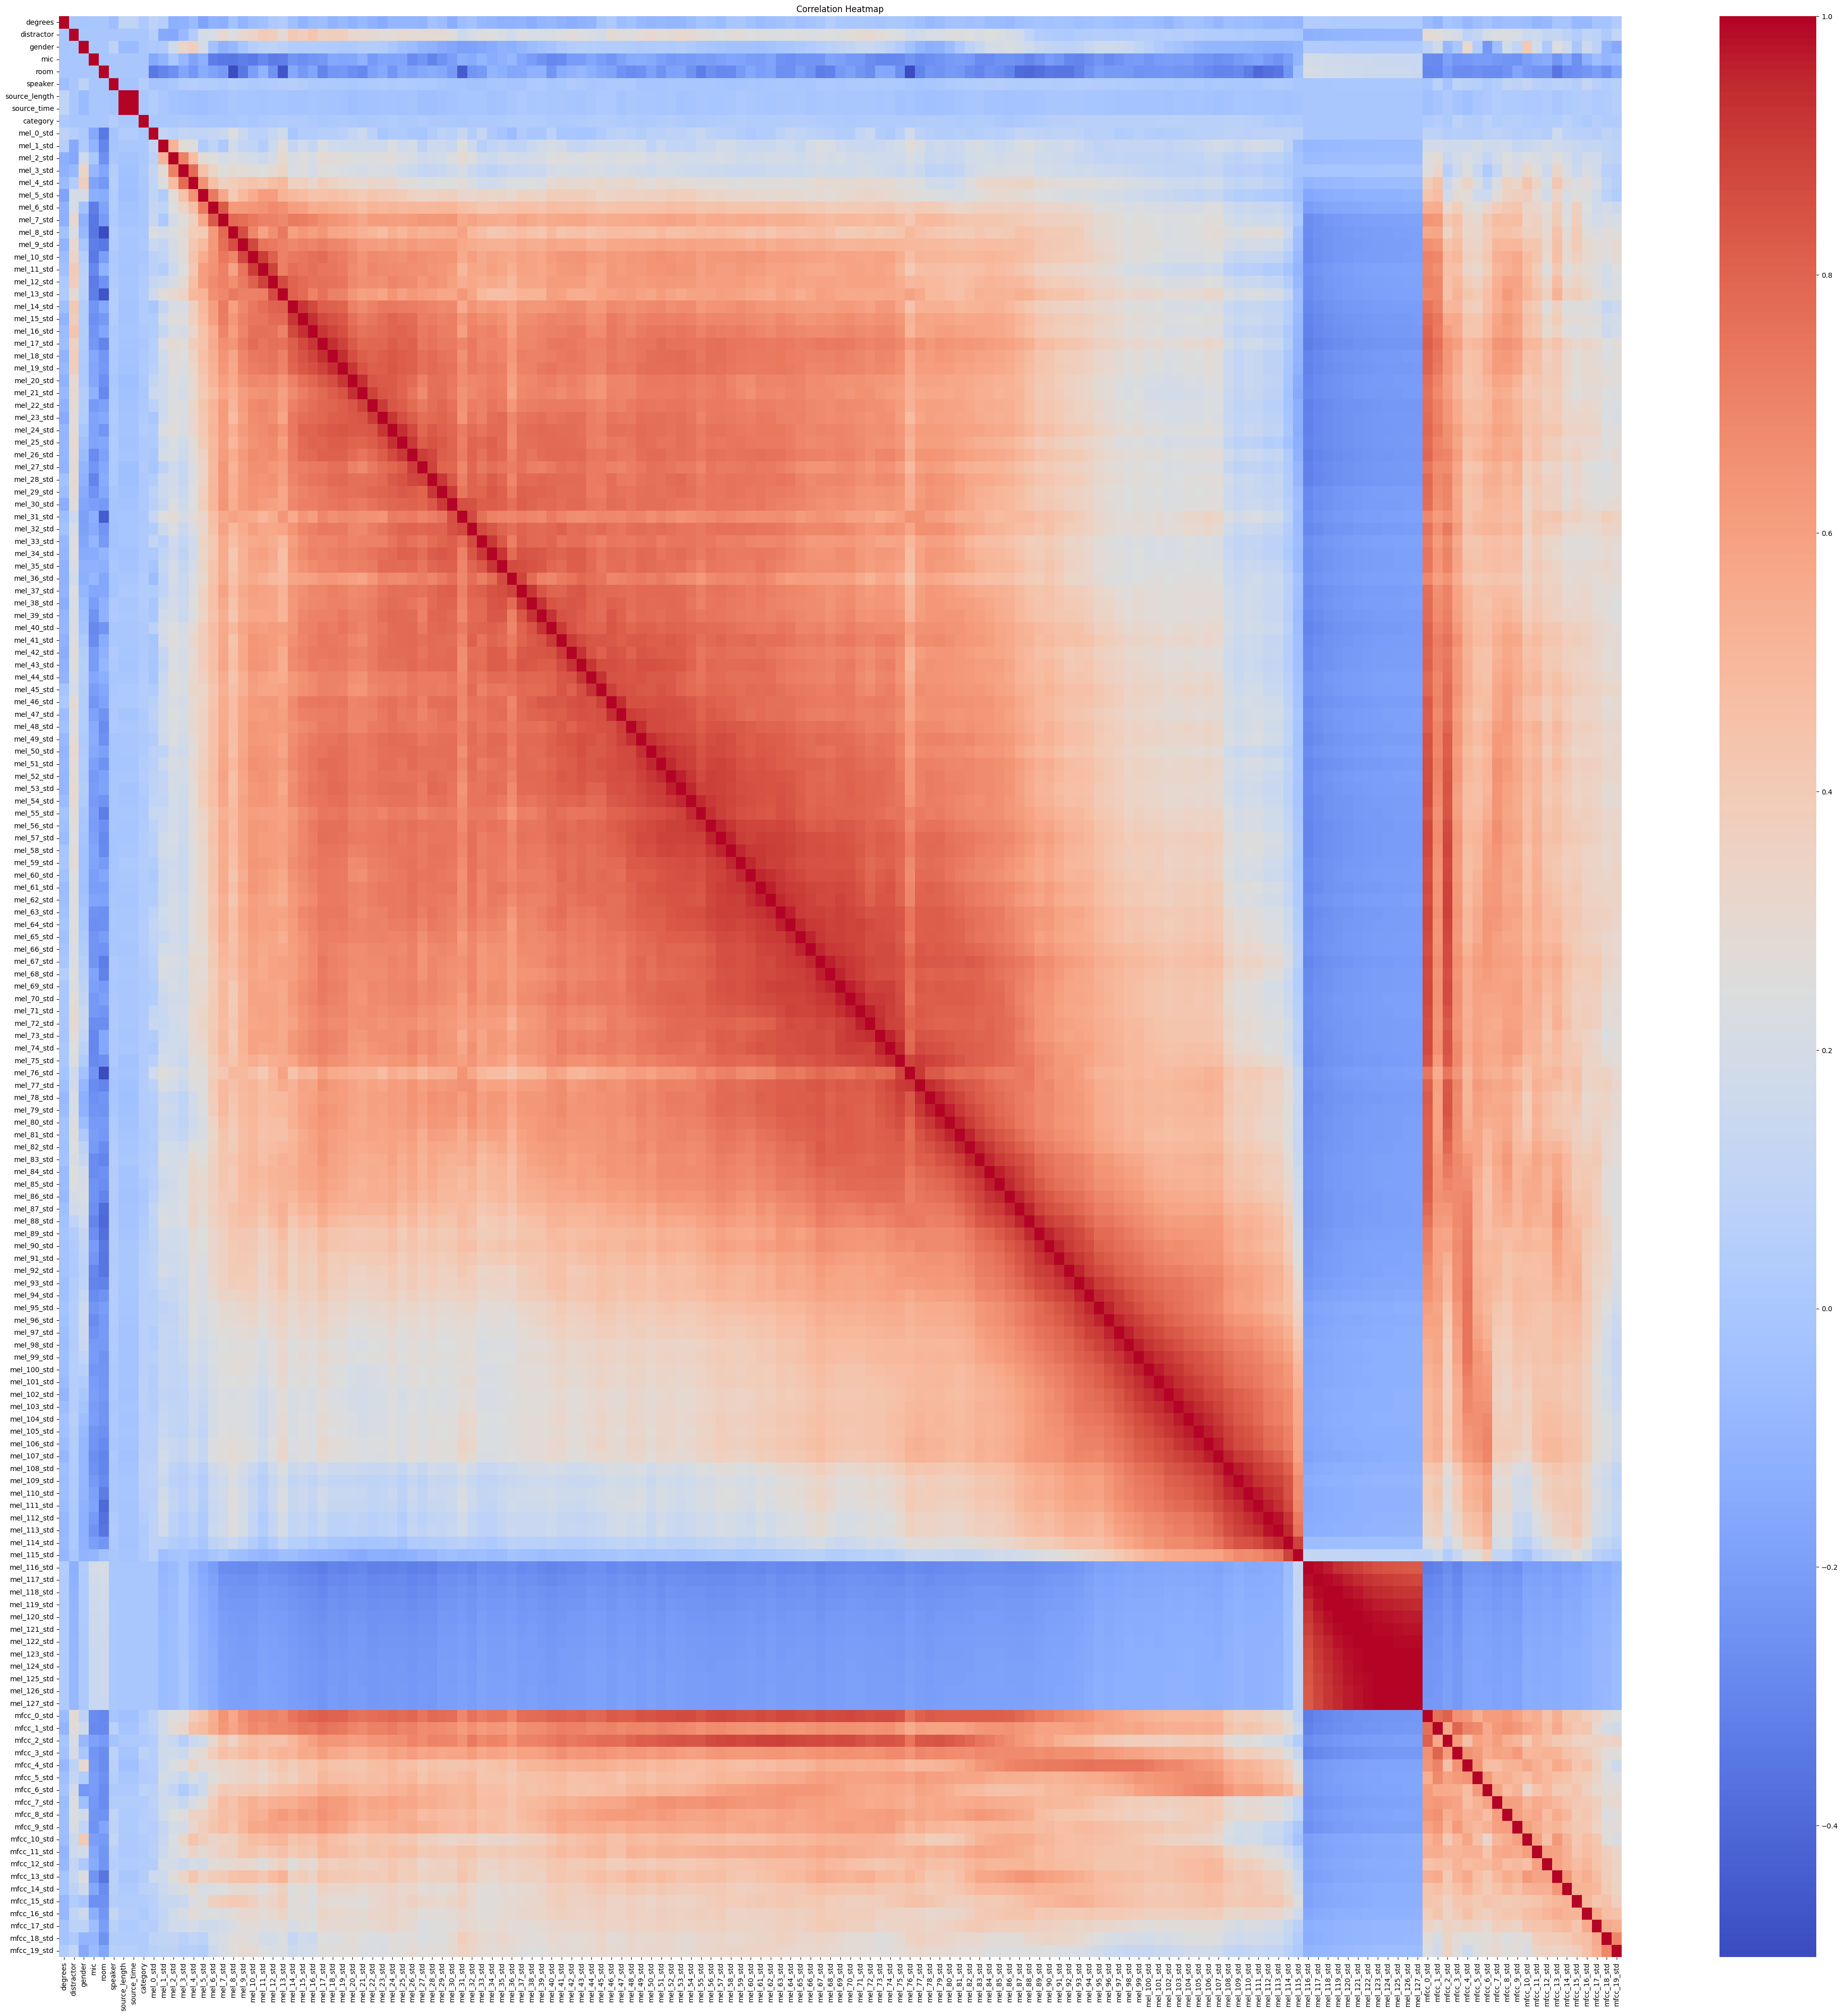

In [19]:
# Calculate the correlation matrix

df = df_processed_2.loc[:, ~df_processed_2.columns.str.endswith(('_max', '_min', '_mean'))]

corr = df.corr()
corr = corr.fillna(0)

plt.figure(figsize=(50, 50))
heatmap = sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

c:\Users\bobmst\Desktop\DSCI\DSCI_Capstone\.conda\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\bobmst\Desktop\DSCI\DSCI_Capstone\.conda\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


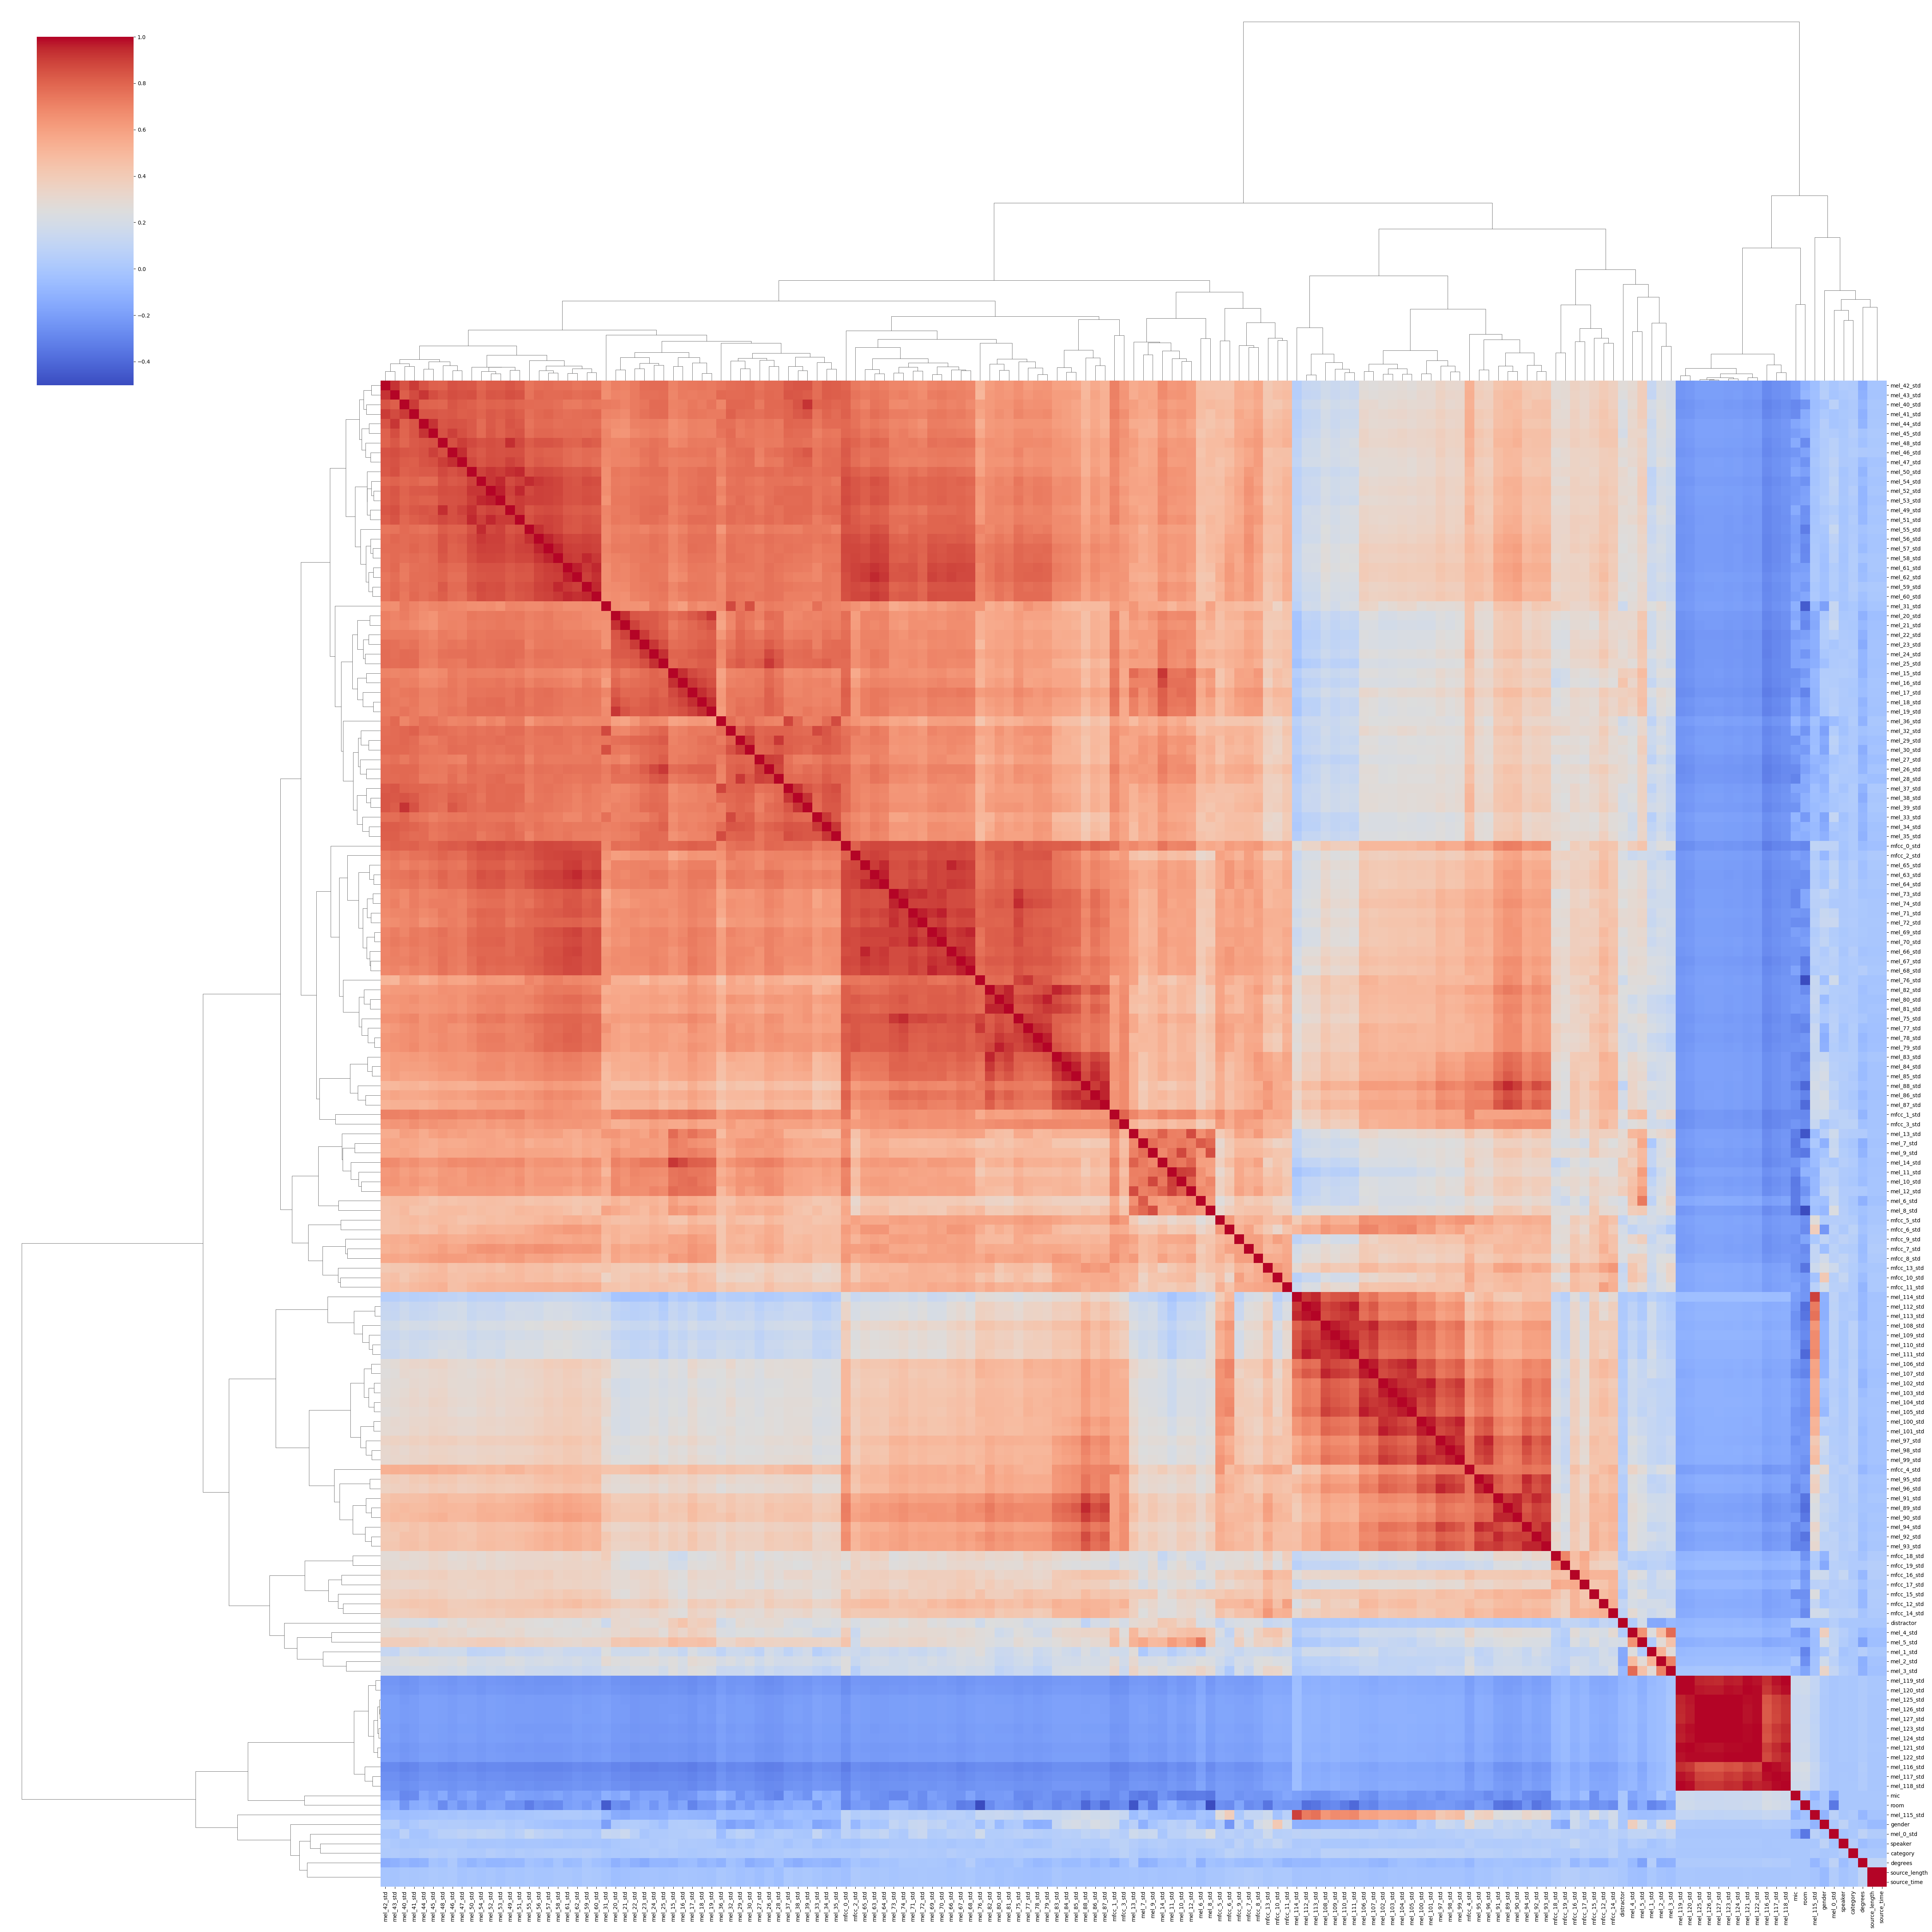

In [20]:
# Clusted heatmap

# Use hierarchical clustering to group similar columns together
g = sns.clustermap(corr, cmap='coolwarm', figsize=(50, 50))

# Rotate the column labels for better visibility
for label in g.ax_heatmap.get_yticklabels():
    label.set_rotation(0)


In [21]:
df_corr.columns

Index(['speaker', 'mel_0_mean', 'mel_0_std', 'mel_1_mean', 'mel_1_std',
       'mel_2_mean', 'mel_2_std', 'mel_3_mean', 'mel_3_std', 'mel_4_mean',
       ...
       'mfcc_15_mean', 'mfcc_15_std', 'mfcc_16_mean', 'mfcc_16_std',
       'mfcc_17_mean', 'mfcc_17_std', 'mfcc_18_mean', 'mfcc_18_std',
       'mfcc_19_mean', 'mfcc_19_std'],
      dtype='object', length=297)

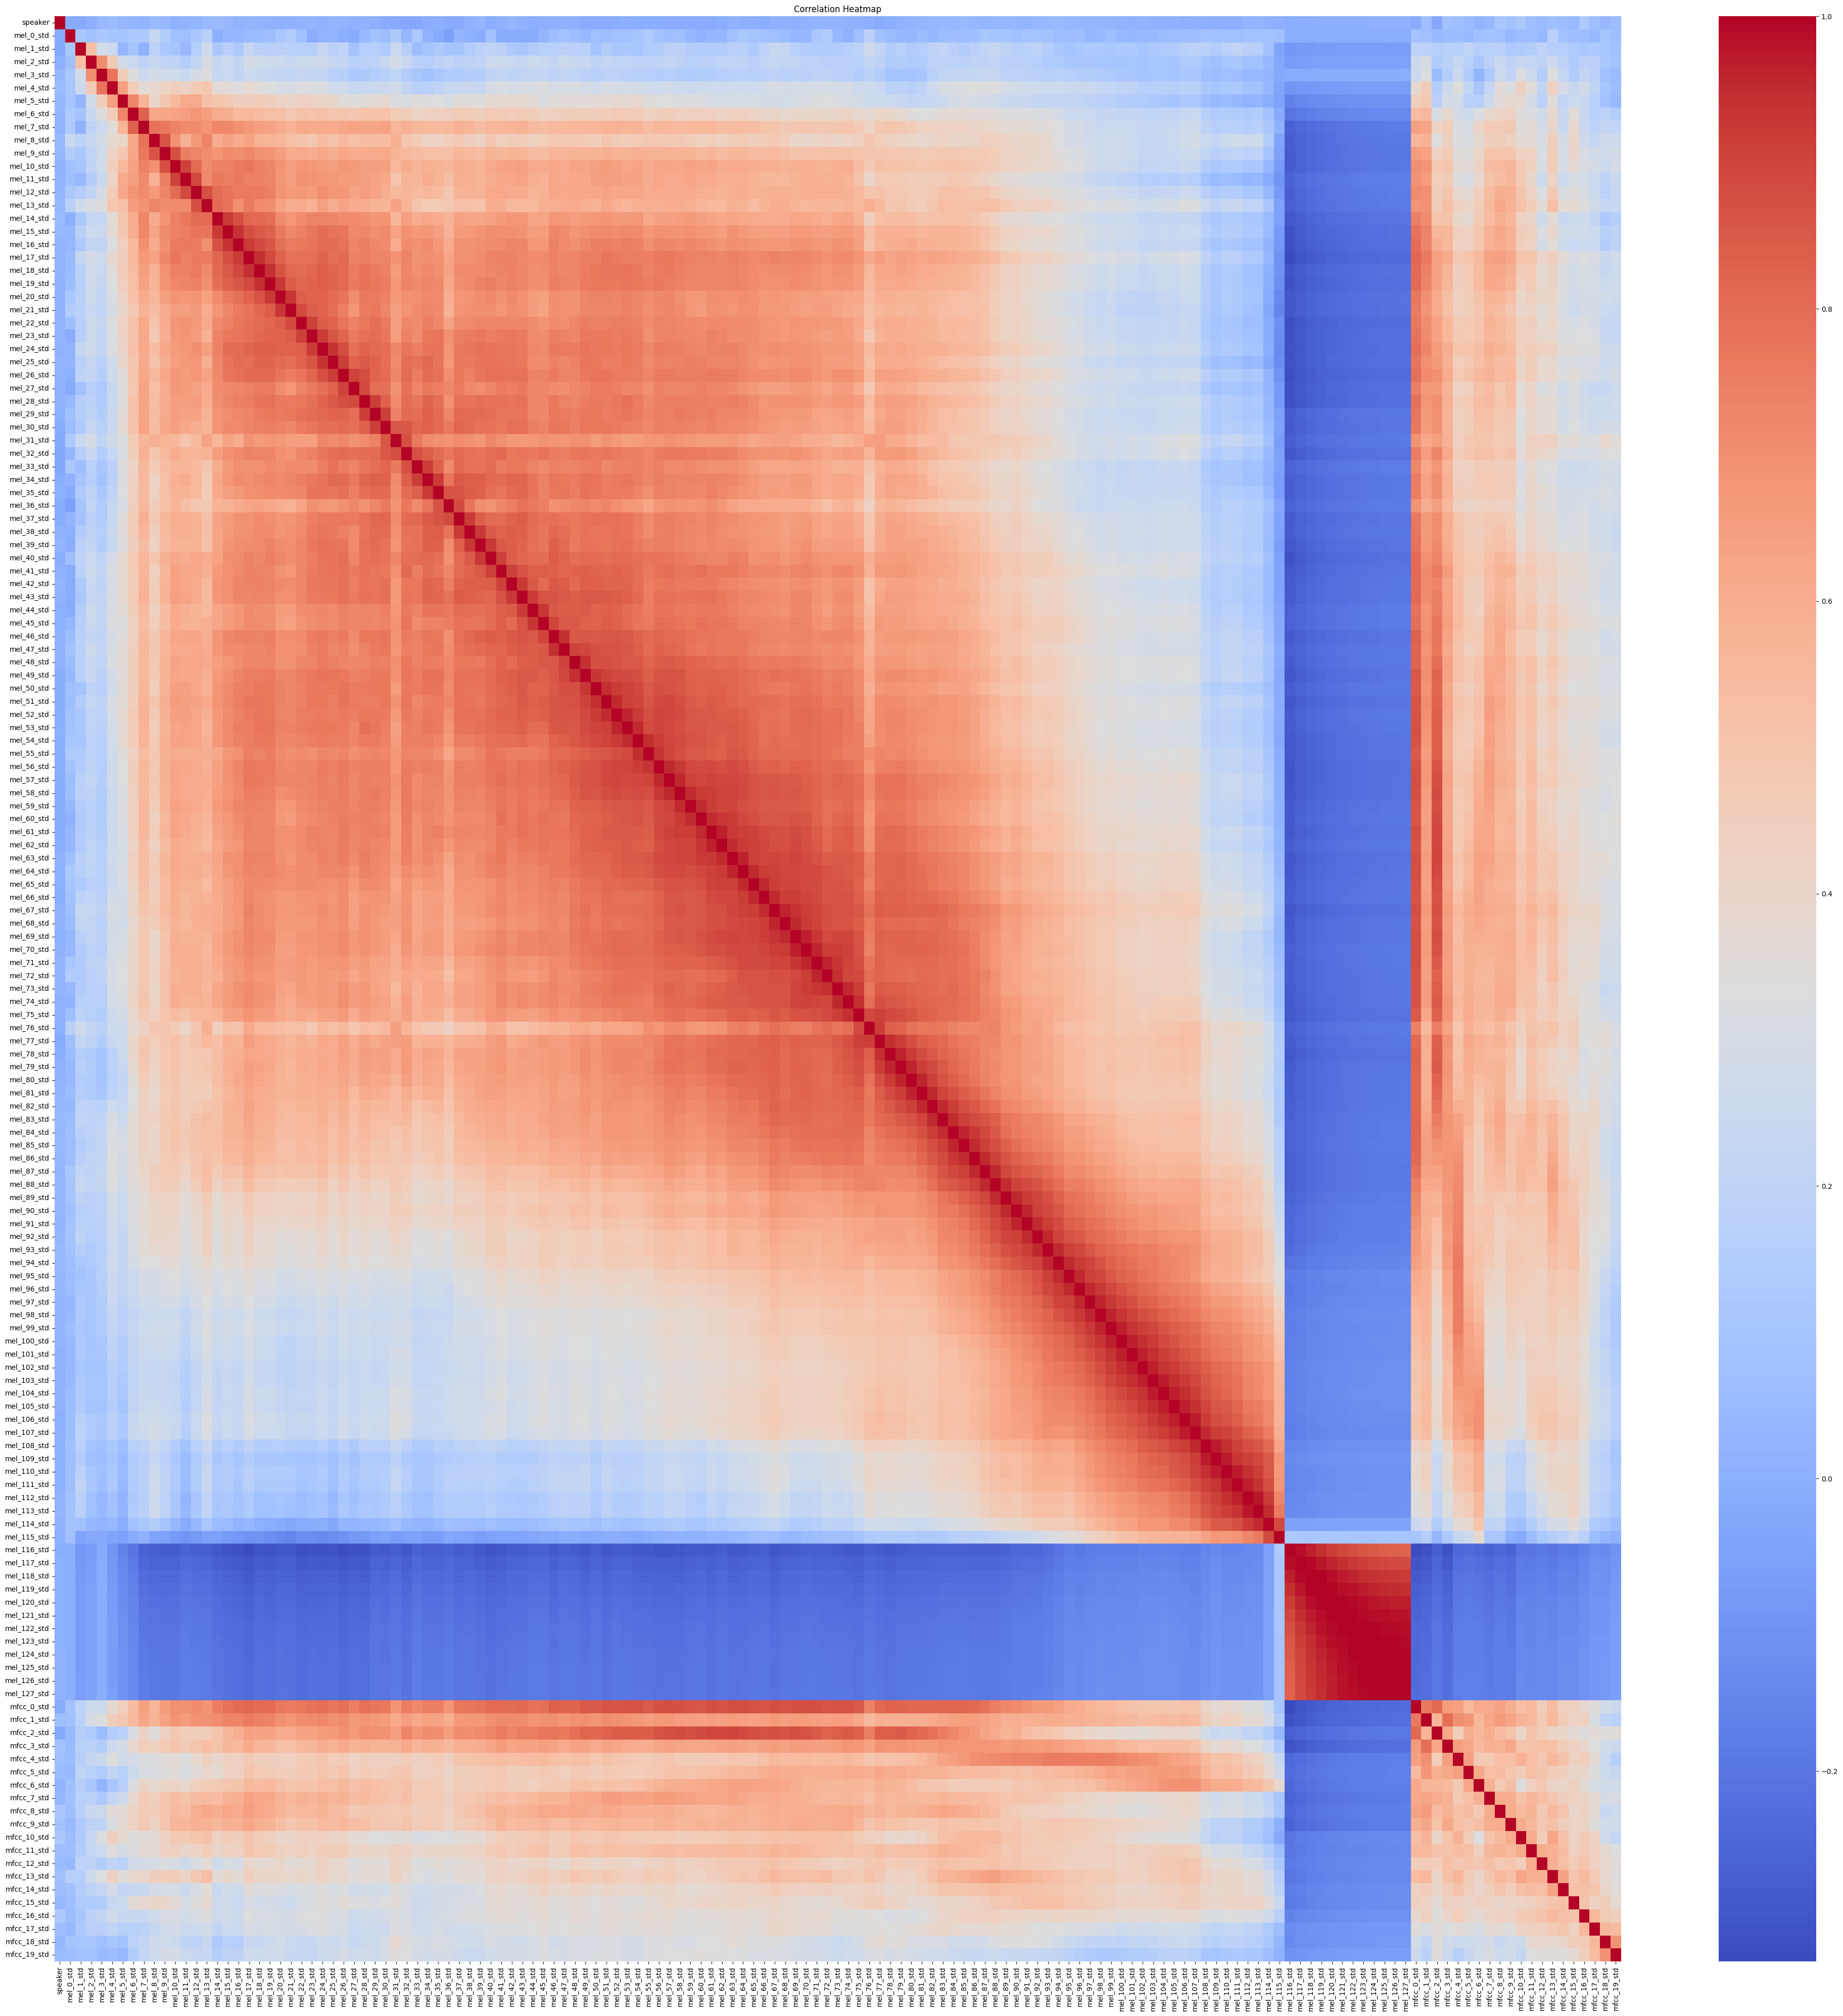

In [22]:
df_corr_partial = df_corr.filter(regex='_std$|speaker')

# Calculate the correlation matrix
corr = df_corr_partial.corr()
corr = corr.fillna(0)

plt.figure(figsize=(50, 50))
heatmap = sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

c:\Users\bobmst\Desktop\DSCI\DSCI_Capstone\.conda\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\bobmst\Desktop\DSCI\DSCI_Capstone\.conda\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


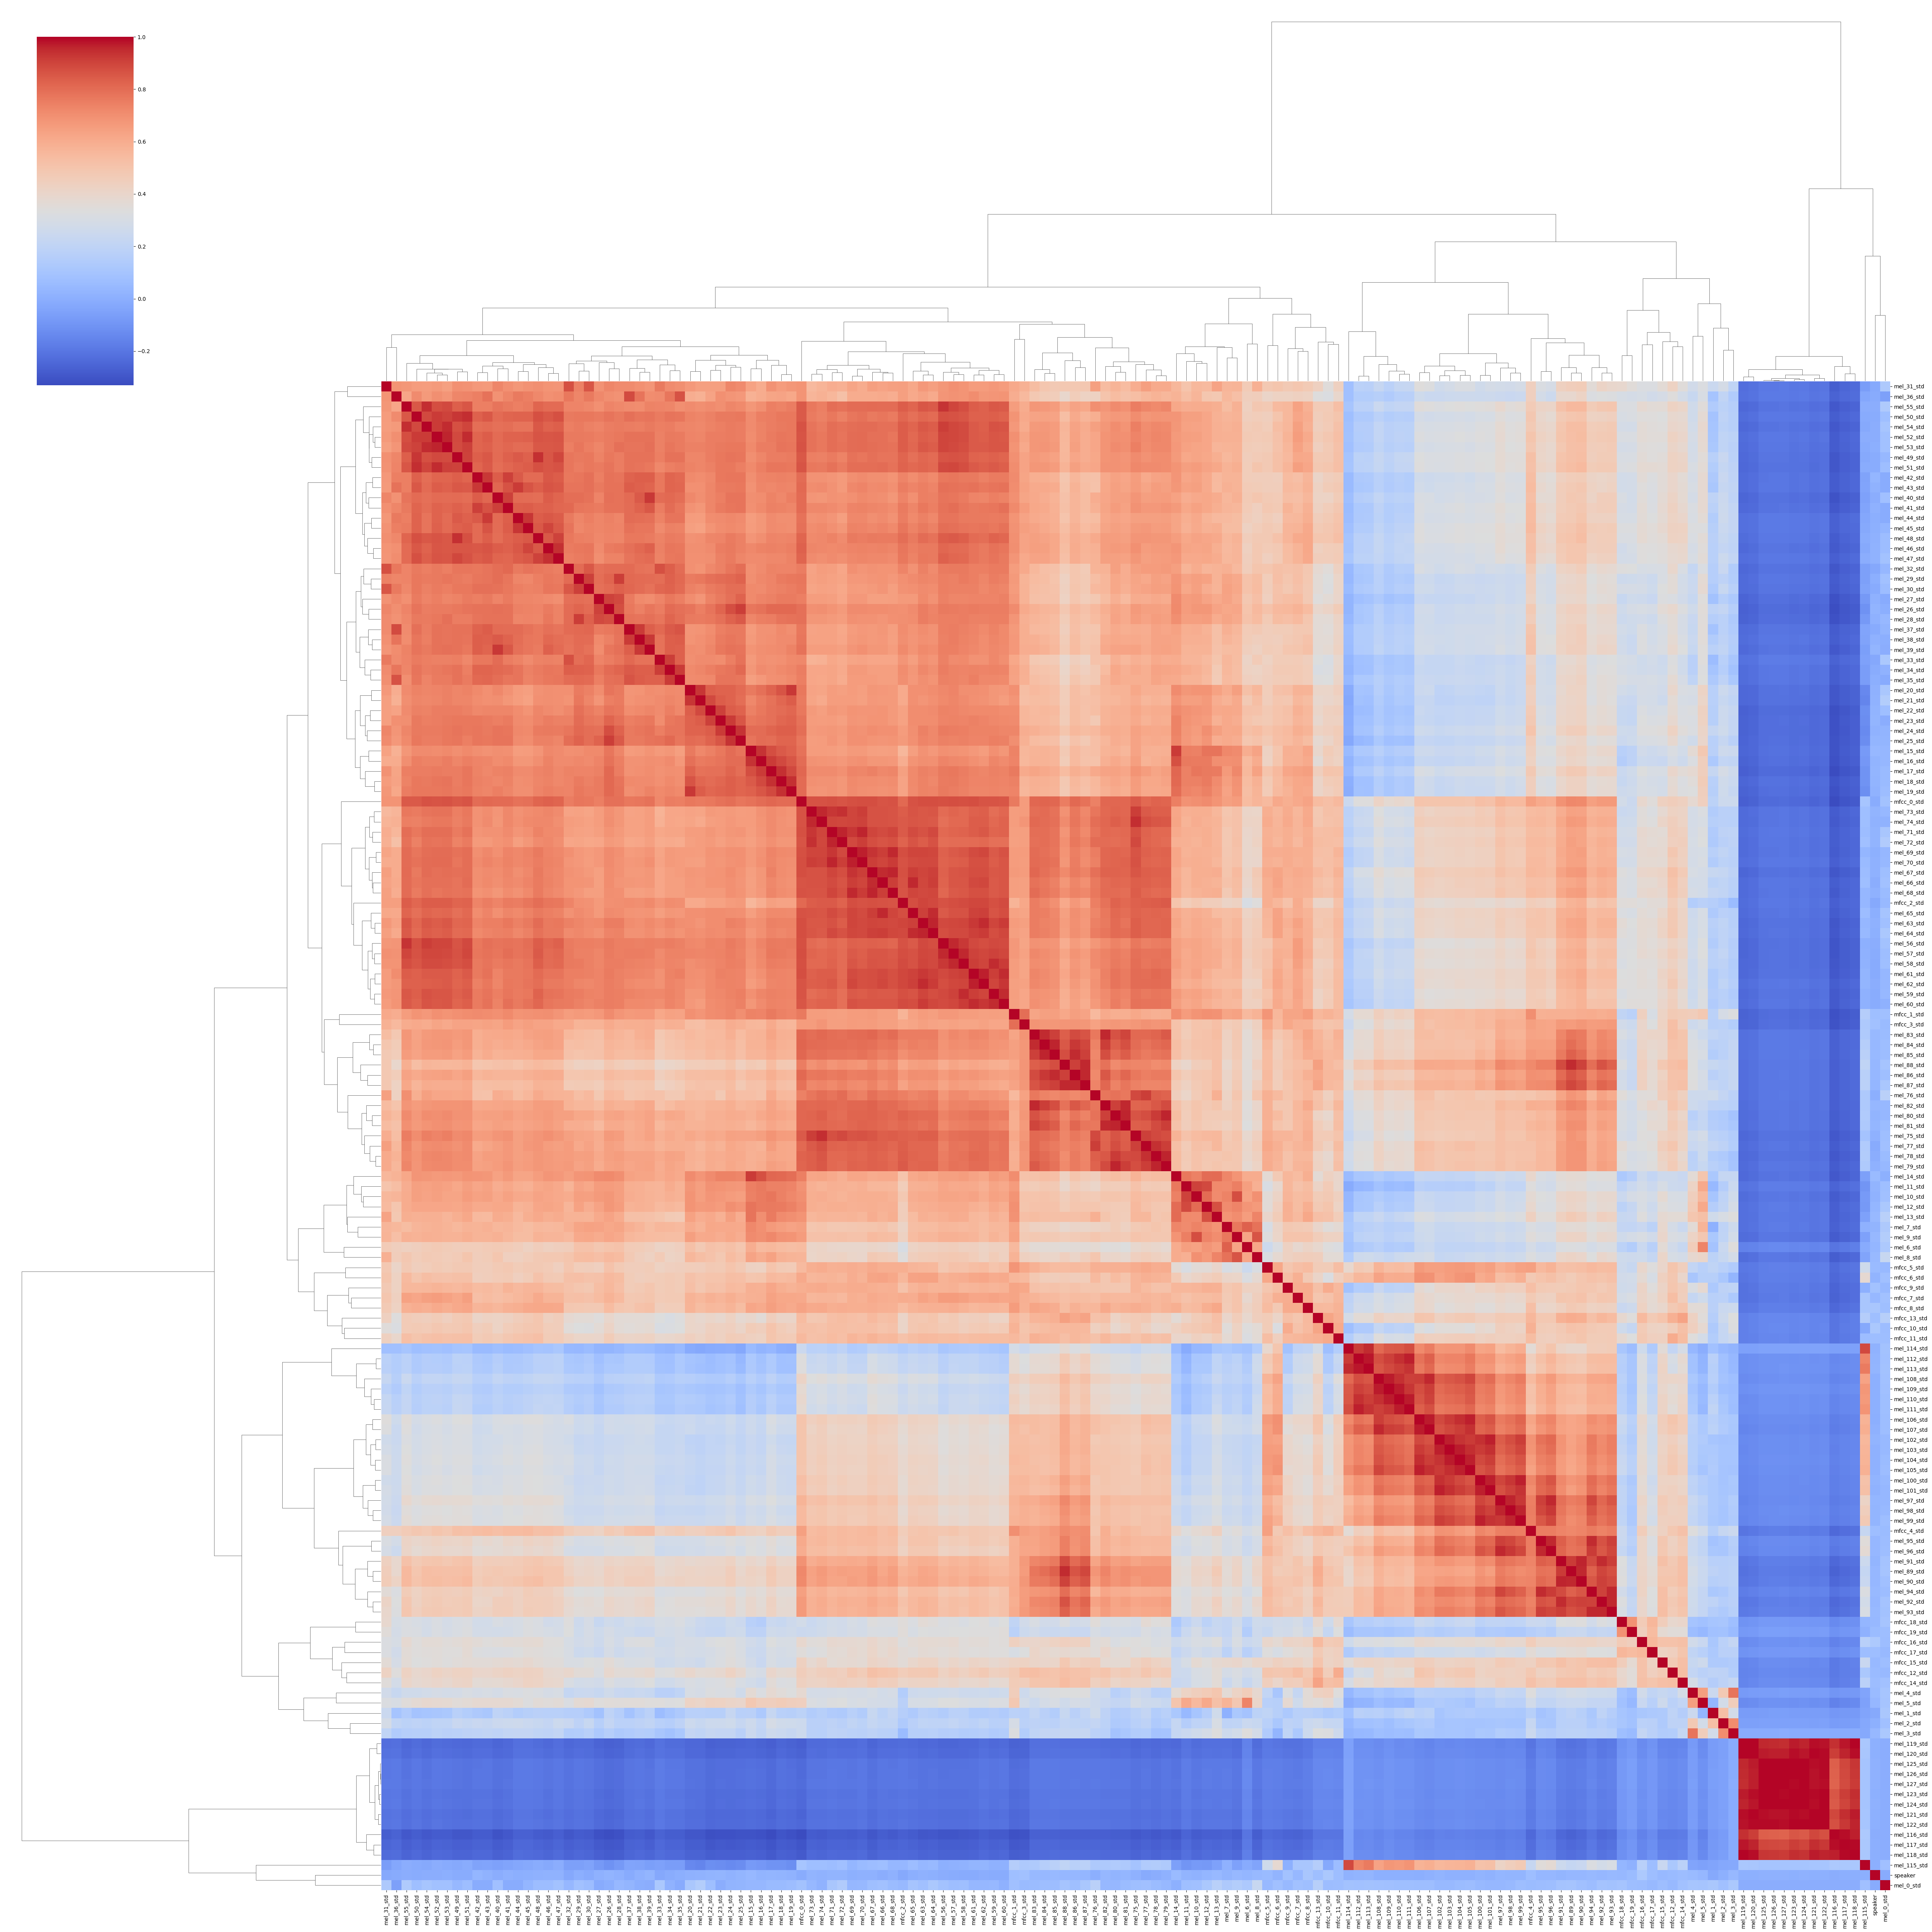

In [23]:
g = sns.clustermap(corr, cmap='coolwarm', figsize=(50, 50))

# Rotate the column labels for better visibility
for label in g.ax_heatmap.get_yticklabels():
    label.set_rotation(0)


In [24]:
df_corr

,speaker,mel_0_mean,mel_0_std,mel_1_mean,mel_1_std,mel_2_mean,mel_2_std,mel_3_mean,mel_3_std,mel_4_mean,...,mfcc_15_mean,mfcc_15_std,mfcc_16_mean,mfcc_16_std,mfcc_17_mean,mfcc_17_std,mfcc_18_mean,mfcc_18_std,mfcc_19_mean,mfcc_19_std
0,4899,-4.484235,0.320470,-3.951655,0.335596,-4.410698,0.318250,-4.349406,0.339291,-4.271053,...,-0.234926,0.635863,0.069191,0.612828,-0.034859,0.597315,0.063703,0.720811,0.255371,0.656739
1,4899,-3.234451,0.343662,-2.882986,0.337417,-3.032111,0.358871,-3.528664,0.340702,-3.571146,...,-0.255411,0.530061,0.675375,0.504203,-0.063383,0.559009,0.348555,0.550831,0.087109,0.549244
2,4899,-5.331490,0.329387,-4.331840,0.218255,-4.028818,0.368321,-2.706367,0.558401,-2.274271,...,-1.068465,0.574085,-0.235911,0.546243,-0.853227,0.587465,-0.019368,0.561328,-0.570055,0.545911
3,4899,-6.587563,0.262332,-5.881702,0.356222,-5.220959,0.368756,-4.100572,0.394792,-3.628301,...,-1.113704,0.676677,-0.678982,0.595795,-0.532142,0.603103,-0.572886,0.632340,-0.278188,0.618203
4,1447,-5.955256,0.333159,-5.165246,0.362272,-4.835852,0.444728,-3.919172,0.399868,-3.315882,...,-1.334682,0.581327,-0.600092,0.462664,-0.766244,0.426755,-0.498948,0.534863,-0.129595,0.435491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,2673,-3.212778,0.319764,-2.697507,0.349960,-3.110861,0.330321,-3.342095,0.412605,-3.927817,...,-0.402409,0.609593,0.631586,0.602320,-0.026373,0.694410,0.401211,0.501564,0.643355,0.691259
19196,1212,-2.667733,0.326268,-2.281094,0.329553,-2.350330,0.359711,-3.314141,0.303593,-3.949166,...,-0.190316,0.543521,1.392509,0.523867,-0.305557,0.553666,0.181702,0.565212,0.654781,0.634878
19197,1212,-4.048009,0.318607,-3.526780,0.365929,-3.901648,0.316600,-4.309596,0.329363,-5.049267,...,-0.202829,0.609548,0.864445,0.547282,-0.030312,0.622354,0.055463,0.547460,0.980605,0.642305
19198,1212,-3.519573,0.352752,-2.982257,0.338330,-3.425498,0.349189,-3.875159,0.358641,-4.553308,...,-0.529172,0.571464,0.620648,0.544762,0.627302,0.476814,0.100000,0.540052,0.024584,0.504623


In [25]:
df_mel = df_corr.filter(regex='mel_')
df_mel_mean = df_mel.filter(regex='_mean$')
df_mel_std = df_mel.filter(regex='_std$')


In [26]:
df_mfcc = df_corr.filter(regex='mfcc_')
df_mfcc_mean = df_mfcc.filter(regex='_mean$')
df_mfcc_std = df_mfcc.filter(regex='_std$')

In [27]:
def draw_PCA(df):
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    # Run PCA
    pca = PCA()
    pca.fit(scaled_data)

    # Plot the variance explained per number of components
    plt.figure(figsize=(8, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Variance Explained per Number of Components')
    plt.show()

def draw_PCA_filted(df):
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    
    # Run PCA
    pca = PCA()
    pca.fit(scaled_data)
    
    # Calculate the cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Determine the optimized number of components
    n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Select components capturing 95% of the variance
    
    # Plot the variance explained per number of components
    plt.figure(figsize=(8, 6))
    plt.plot(cumulative_variance)
    plt.axvline(x=n_components, color='r', linestyle='--', label=f'{n_components} components (95% variance)')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Variance Explained per Number of Components')
    plt.legend()
    plt.show()


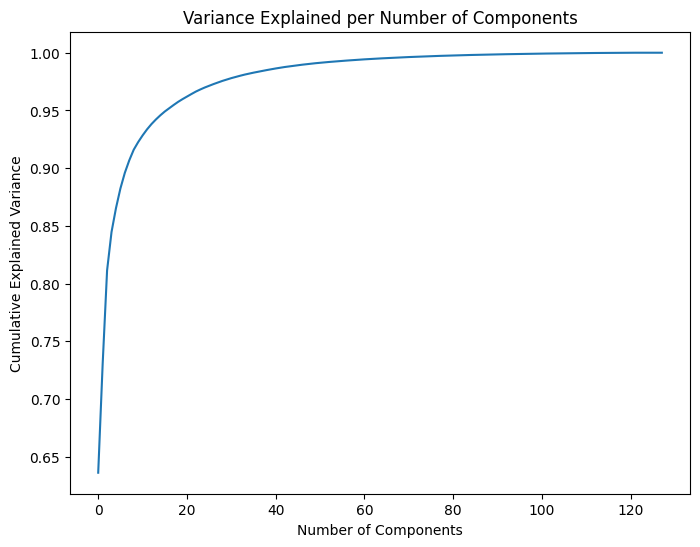

In [28]:
draw_PCA(df_mel_mean)

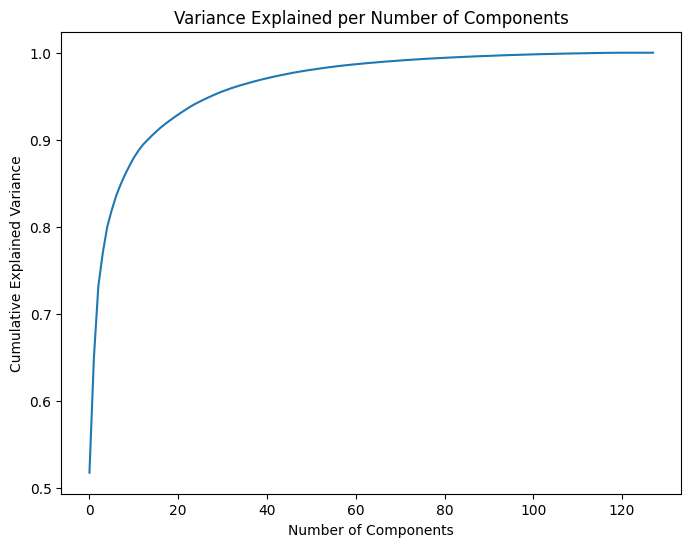

In [29]:
draw_PCA(df_mel_std)

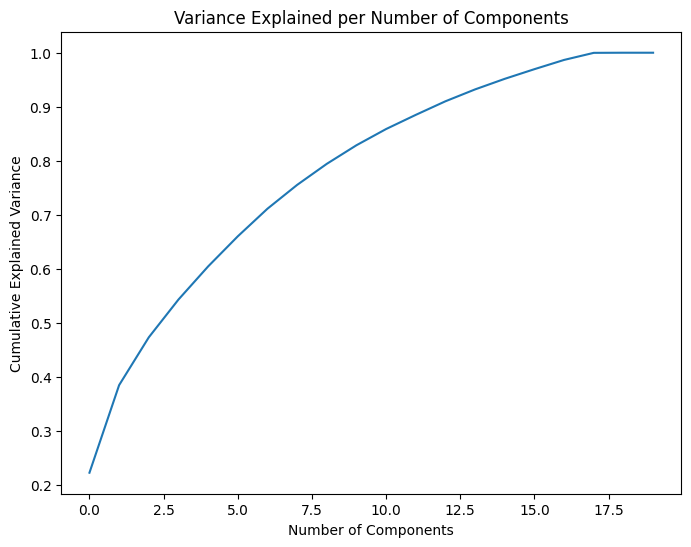

In [30]:
draw_PCA(df_mfcc_mean)

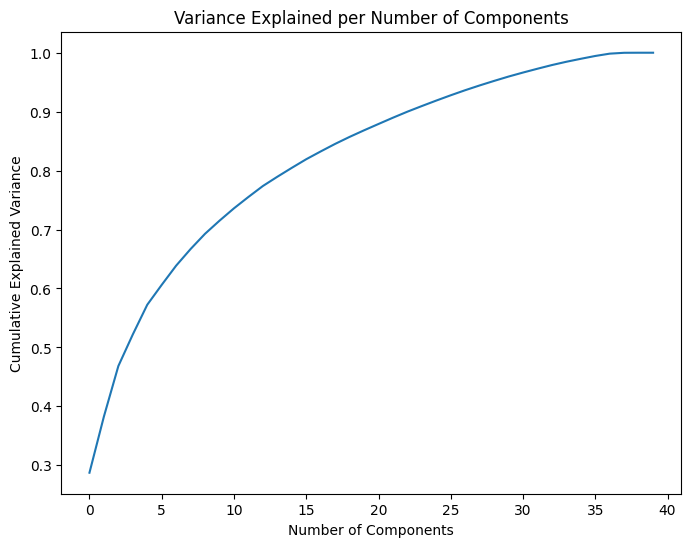

In [31]:
draw_PCA(df_mfcc)

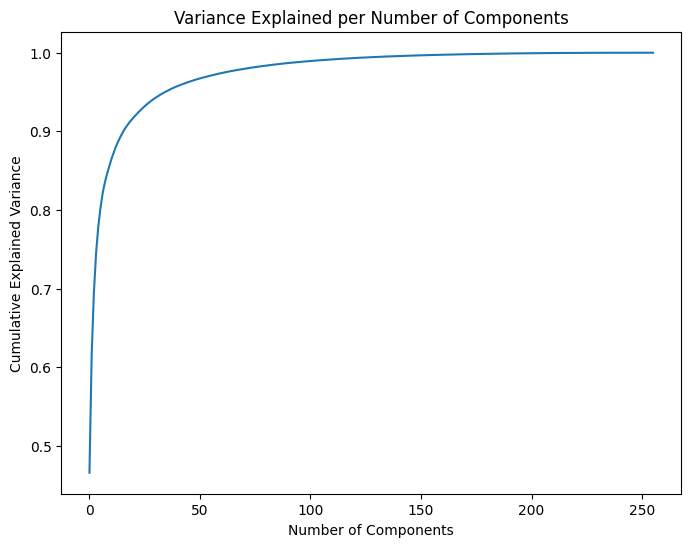

In [32]:
draw_PCA(df_mel)

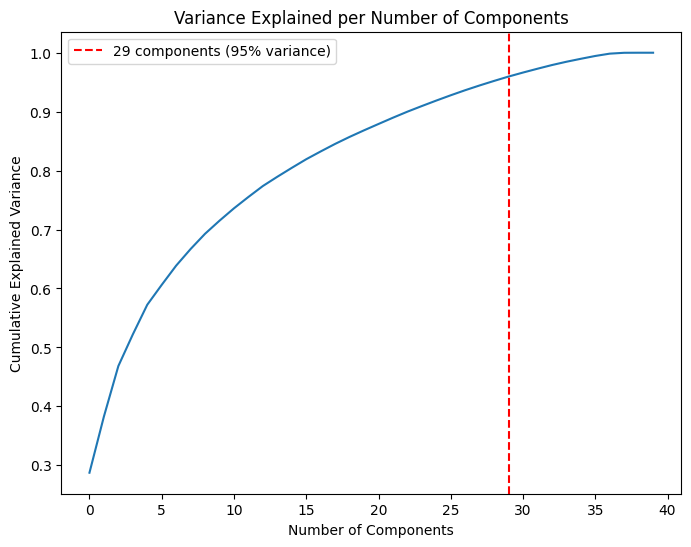

In [33]:
draw_PCA_filted(df_mfcc)

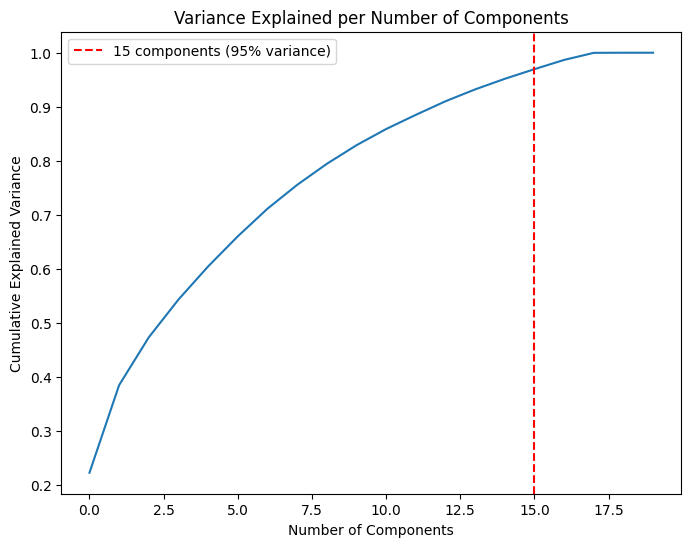

In [34]:
draw_PCA_filted(df_mfcc_mean)

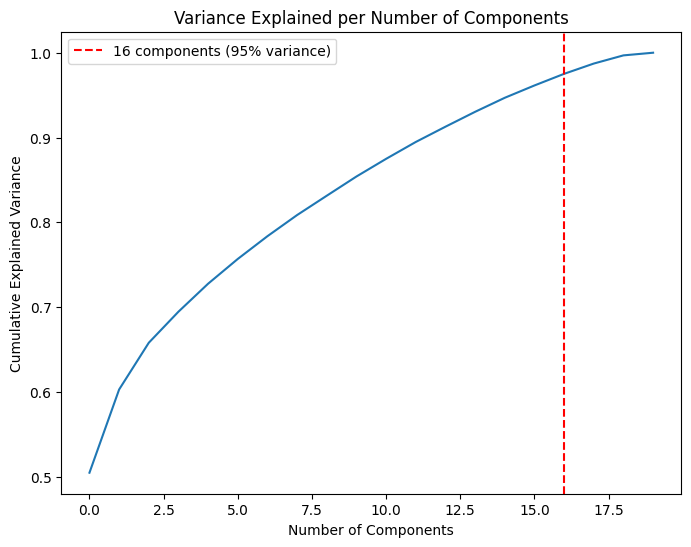

In [35]:
draw_PCA_filted(df_mfcc_std)

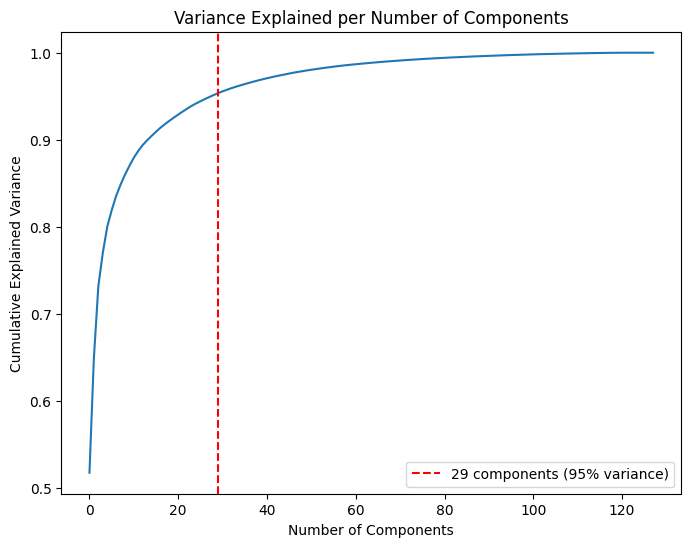

In [36]:
draw_PCA_filted(df_mel_std)

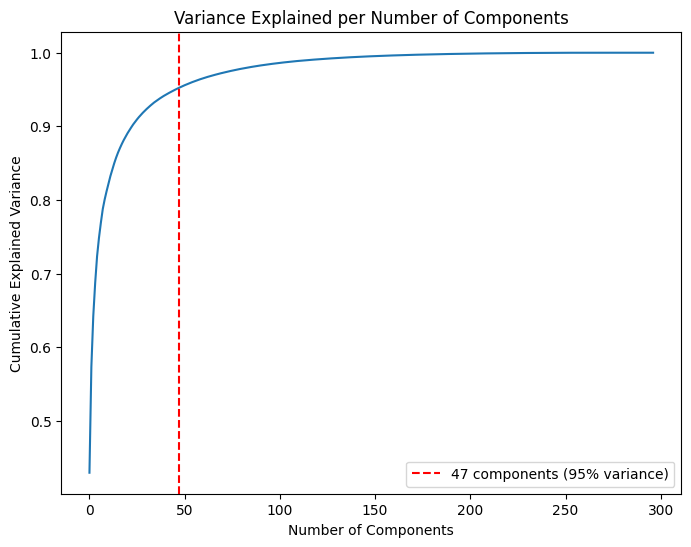

In [37]:
draw_PCA_filted(df_corr)